## 1. Setup and Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths
PROJECT_ROOT = Path().absolute().parent.parent
RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
FIGURES_DIR = PROJECT_ROOT / 'outputs' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("📦 Imports successful!")
print(f"📁 Results directory: {RESULTS_DIR}")
print(f"📁 Figures directory: {FIGURES_DIR}")

📦 Imports successful!
📁 Results directory: d:\SEM7\Generative AI\Project\financial-timeseries-generation\outputs\results
📁 Figures directory: d:\SEM7\Generative AI\Project\financial-timeseries-generation\outputs\figures


## 2. Load Results from Both Models

In [4]:
# List of all assets
assets = ['GSPC', 'FTSE', 'DJI', 'N225', 'HSI', 'IXIC', 'BTC-USD', 'AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA']

# Initialize comparison data
comparison_data = []

for ticker in assets:
    # Adjust ticker for file naming
    ticker_file = ticker.replace('-', '_')
    
    # TimeGAN results
    timegan_path = RESULTS_DIR / f'timegan_evaluation_{ticker_file}.csv'
    # Diffusion results
    diffusion_path = RESULTS_DIR / f'diffusion_evaluation_{ticker_file}.csv'
    
    row = {'Asset': ticker}
    
    # Load TimeGAN results (only has Mean_Diff, no KS stat)
    if timegan_path.exists():
        tg_df = pd.read_csv(timegan_path)
        # Handle inf values in Mean_Diff
        mean_diff = tg_df['Mean_Diff'].replace([np.inf, -np.inf], np.nan).abs()
        row['TimeGAN_MeanDiff'] = mean_diff.mean(skipna=True)
    else:
        row['TimeGAN_MeanDiff'] = np.nan
    
    # Load Diffusion results (has both KS and Mean_Diff)
    if diffusion_path.exists():
        diff_df = pd.read_csv(diffusion_path)
        row['Diffusion_KS'] = diff_df['KS_Stat'].mean()
        row['Diffusion_MeanDiff'] = diff_df['Mean_Diff'].abs().mean()
    else:
        row['Diffusion_KS'] = np.nan
        row['Diffusion_MeanDiff'] = np.nan
    
    comparison_data.append(row)

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Calculate improvements (negative means Diffusion is better for Mean Diff)
comparison_df['MeanDiff_Improvement'] = comparison_df['Diffusion_MeanDiff'] - comparison_df['TimeGAN_MeanDiff']

# Determine winner for each asset based on Mean Diff
comparison_df['MeanDiff_Winner'] = comparison_df['MeanDiff_Improvement'].apply(
    lambda x: 'Diffusion' if x < -0.01 else ('TimeGAN' if x > 0.01 else 'Tie') if pd.notna(x) else 'N/A'
)

print("\n" + "="*100)
print("📊 TIMEGAN vs DIFFUSION - DETAILED COMPARISON")
print("="*100)
print("\nNote: TimeGAN results don't include KS statistics, only Diffusion model has KS values.")
print("Comparison is based on Mean Difference (lower is better).\n")
print(comparison_df.to_string(index=False))
print("="*100)

# Save comparison
comparison_path = RESULTS_DIR / 'model_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"\n💾 Comparison saved to {comparison_path}")



📊 TIMEGAN vs DIFFUSION - DETAILED COMPARISON

Note: TimeGAN results don't include KS statistics, only Diffusion model has KS values.
Comparison is based on Mean Difference (lower is better).

  Asset  TimeGAN_MeanDiff  Diffusion_KS  Diffusion_MeanDiff  MeanDiff_Improvement MeanDiff_Winner
   GSPC          0.120551      0.388568            0.123071              0.002520             Tie
   FTSE          0.034445      0.482890            0.168117              0.133672         TimeGAN
    DJI          0.055895      0.412879            0.139971              0.084076         TimeGAN
   N225          0.058871      0.365491            0.110957              0.052086         TimeGAN
    HSI          0.025563      0.348927            0.110226              0.084663         TimeGAN
   IXIC          0.064425      0.370478            0.123030              0.058605         TimeGAN
BTC-USD               NaN      0.440643            0.173840                   NaN             N/A
   AAPL          0.1055

## 3. Summary Statistics

In [5]:
# Overall statistics
print("\n" + "="*100)
print("📈 OVERALL PERFORMANCE SUMMARY")
print("="*100)

# Filter out NaN values for valid comparisons
valid_df = comparison_df.dropna(subset=['TimeGAN_MeanDiff', 'Diffusion_MeanDiff'])

print(f"\n🔢 Number of assets compared: {len(valid_df)}/{len(assets)}")

# Average Mean Difference metrics
print("\n📊 Average Mean Difference:")
print(f"   TimeGAN:   {valid_df['TimeGAN_MeanDiff'].mean():.4f} ± {valid_df['TimeGAN_MeanDiff'].std():.4f}")
print(f"   Diffusion: {valid_df['Diffusion_MeanDiff'].mean():.4f} ± {valid_df['Diffusion_MeanDiff'].std():.4f}")
avg_md_improvement = valid_df['MeanDiff_Improvement'].mean()
print(f"   Improvement: {avg_md_improvement:.4f} ({avg_md_improvement/valid_df['TimeGAN_MeanDiff'].mean()*100:+.2f}%)")

# Diffusion KS statistics (only available for Diffusion)
diffusion_ks_df = comparison_df.dropna(subset=['Diffusion_KS'])
print("\n📊 Diffusion Model - KS Statistics:")
print(f"   Average: {diffusion_ks_df['Diffusion_KS'].mean():.4f} ± {diffusion_ks_df['Diffusion_KS'].std():.4f}")
print(f"   Min: {diffusion_ks_df['Diffusion_KS'].min():.4f} ({comparison_df.loc[comparison_df['Diffusion_KS'].idxmin(), 'Asset']})")
print(f"   Max: {diffusion_ks_df['Diffusion_KS'].max():.4f} ({comparison_df.loc[comparison_df['Diffusion_KS'].idxmax(), 'Asset']})")

# Winner counts
print("\n🏆 Winner Count (Mean Difference):")
md_winners = valid_df['MeanDiff_Winner'].value_counts()
for model, count in md_winners.items():
    print(f"   {model}: {count}/{len(valid_df)} ({count/len(valid_df)*100:.1f}%)")

# Best performers
print("\n⭐ Best Performers (Mean Difference):")
best_timegan = valid_df.nsmallest(3, 'TimeGAN_MeanDiff')[['Asset', 'TimeGAN_MeanDiff']]
best_diffusion = valid_df.nsmallest(3, 'Diffusion_MeanDiff')[['Asset', 'Diffusion_MeanDiff']]

print("\n   TimeGAN Top 3 (lowest Mean Diff):")
for idx, row in best_timegan.iterrows():
    print(f"      {row['Asset']}: {row['TimeGAN_MeanDiff']:.4f}")

print("\n   Diffusion Top 3 (lowest Mean Diff):")
for idx, row in best_diffusion.iterrows():
    print(f"      {row['Asset']}: {row['Diffusion_MeanDiff']:.4f}")

print("\n⭐ Best Performers (Diffusion KS Statistic):")
best_diffusion_ks = diffusion_ks_df.nsmallest(3, 'Diffusion_KS')[['Asset', 'Diffusion_KS']]
print("\n   Diffusion Top 3 (lowest KS):")
for idx, row in best_diffusion_ks.iterrows():
    print(f"      {row['Asset']}: {row['Diffusion_KS']:.4f}")

print("\n" + "="*100)



📈 OVERALL PERFORMANCE SUMMARY

🔢 Number of assets compared: 11/12

📊 Average Mean Difference:
   TimeGAN:   0.0674 ± 0.0334
   Diffusion: 0.1273 ± 0.0187
   Improvement: 0.0599 (+88.89%)

📊 Diffusion Model - KS Statistics:
   Average: 0.3900 ± 0.0428
   Min: 0.3210 (AMZN)
   Max: 0.4829 (FTSE)

🏆 Winner Count (Mean Difference):
   TimeGAN: 9/11 (81.8%)
   Tie: 2/11 (18.2%)

⭐ Best Performers (Mean Difference):

   TimeGAN Top 3 (lowest Mean Diff):
      AMZN: 0.0206
      HSI: 0.0256
      FTSE: 0.0344

   Diffusion Top 3 (lowest Mean Diff):
      AMZN: 0.1024
      HSI: 0.1102
      N225: 0.1110

⭐ Best Performers (Diffusion KS Statistic):

   Diffusion Top 3 (lowest KS):
      AMZN: 0.3210
      HSI: 0.3489
      GOOGL: 0.3624



## 4. Visualization - Side-by-Side Comparison

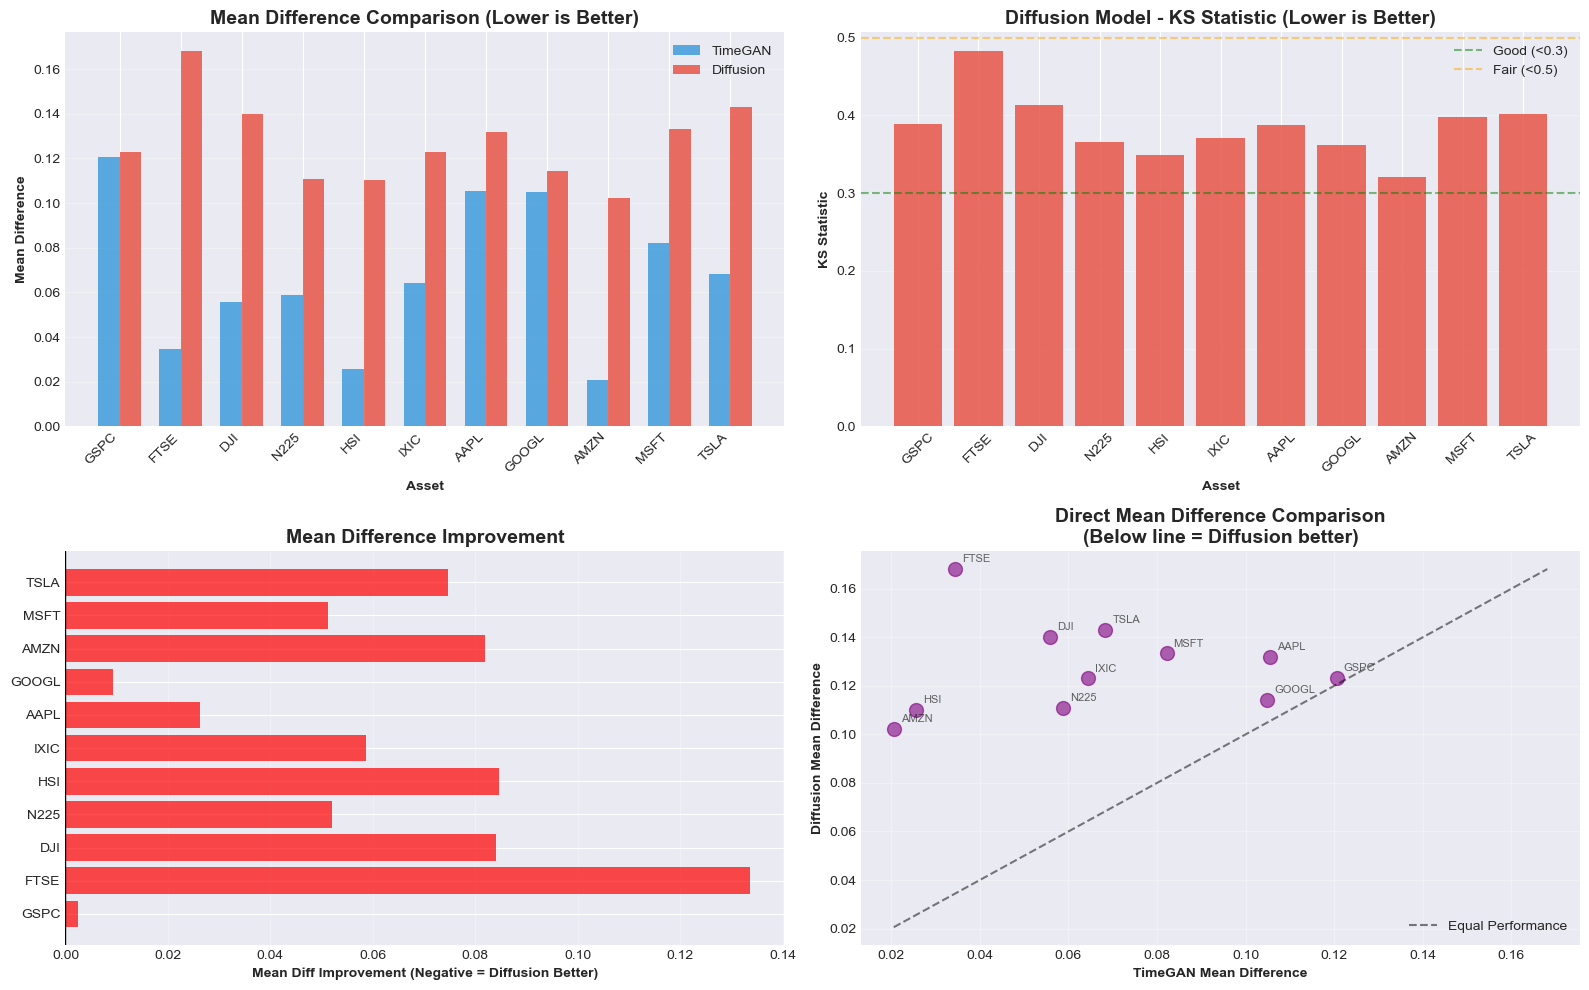


✅ Comparison visualization saved!


In [6]:
# Prepare data for plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Mean Difference Comparison (Bar Chart)
x = np.arange(len(valid_df))
width = 0.35

axes[0, 0].bar(x - width/2, valid_df['TimeGAN_MeanDiff'], width, label='TimeGAN', alpha=0.8, color='#3498db')
axes[0, 0].bar(x + width/2, valid_df['Diffusion_MeanDiff'], width, label='Diffusion', alpha=0.8, color='#e74c3c')
axes[0, 0].set_xlabel('Asset', fontweight='bold')
axes[0, 0].set_ylabel('Mean Difference', fontweight='bold')
axes[0, 0].set_title('Mean Difference Comparison (Lower is Better)', fontweight='bold', fontsize=14)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(valid_df['Asset'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Diffusion KS Statistic (Bar Chart)
diffusion_ks_plot = valid_df[['Asset', 'Diffusion_KS']].copy()
axes[0, 1].bar(diffusion_ks_plot['Asset'], diffusion_ks_plot['Diffusion_KS'], alpha=0.8, color='#e74c3c')
axes[0, 1].set_xlabel('Asset', fontweight='bold')
axes[0, 1].set_ylabel('KS Statistic', fontweight='bold')
axes[0, 1].set_title('Diffusion Model - KS Statistic (Lower is Better)', fontweight='bold', fontsize=14)
axes[0, 1].axhline(y=0.3, color='green', linestyle='--', label='Good (<0.3)', alpha=0.5)
axes[0, 1].axhline(y=0.5, color='orange', linestyle='--', label='Fair (<0.5)', alpha=0.5)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Mean Difference Improvement (negative = Diffusion better)
improvement_data = valid_df[['Asset', 'MeanDiff_Improvement']].set_index('Asset')
colors = ['green' if x < 0 else 'red' for x in improvement_data['MeanDiff_Improvement']]
axes[1, 0].barh(improvement_data.index, improvement_data['MeanDiff_Improvement'], color=colors, alpha=0.7)
axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_xlabel('Mean Diff Improvement (Negative = Diffusion Better)', fontweight='bold')
axes[1, 0].set_title('Mean Difference Improvement', fontweight='bold', fontsize=14)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Scatter Plot - Mean Difference Comparison
axes[1, 1].scatter(valid_df['TimeGAN_MeanDiff'], valid_df['Diffusion_MeanDiff'], s=100, alpha=0.6, c='purple')
for idx, row in valid_df.iterrows():
    axes[1, 1].annotate(row['Asset'], (row['TimeGAN_MeanDiff'], row['Diffusion_MeanDiff']), 
                       fontsize=8, alpha=0.7, xytext=(5,5), textcoords='offset points')

# Add diagonal line (equal performance)
max_val = max(valid_df['TimeGAN_MeanDiff'].max(), valid_df['Diffusion_MeanDiff'].max())
min_val = min(valid_df['TimeGAN_MeanDiff'].min(), valid_df['Diffusion_MeanDiff'].min())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Equal Performance')
axes[1, 1].set_xlabel('TimeGAN Mean Difference', fontweight='bold')
axes[1, 1].set_ylabel('Diffusion Mean Difference', fontweight='bold')
axes[1, 1].set_title('Direct Mean Difference Comparison\n(Below line = Diffusion better)', fontweight='bold', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison visualization saved!")


## 5. Asset Category Analysis

C:\Users\nasir\AppData\Local\Temp\ipykernel_22704\1830247658.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['Category'] = valid_df['Asset'].apply(get_category)



📊 PERFORMANCE BY ASSET CATEGORY
         TimeGAN_MeanDiff         Diffusion_MeanDiff         Diffusion_KS  \
                     mean     std               mean     std         mean   
Category                                                                    
Indices            0.0600  0.0333             0.1292  0.0219       0.3949   
Stocks             0.0763  0.0349             0.1249  0.0163       0.3741   

                  
             std  
Category          
Indices   0.0483  
Stocks    0.0334  


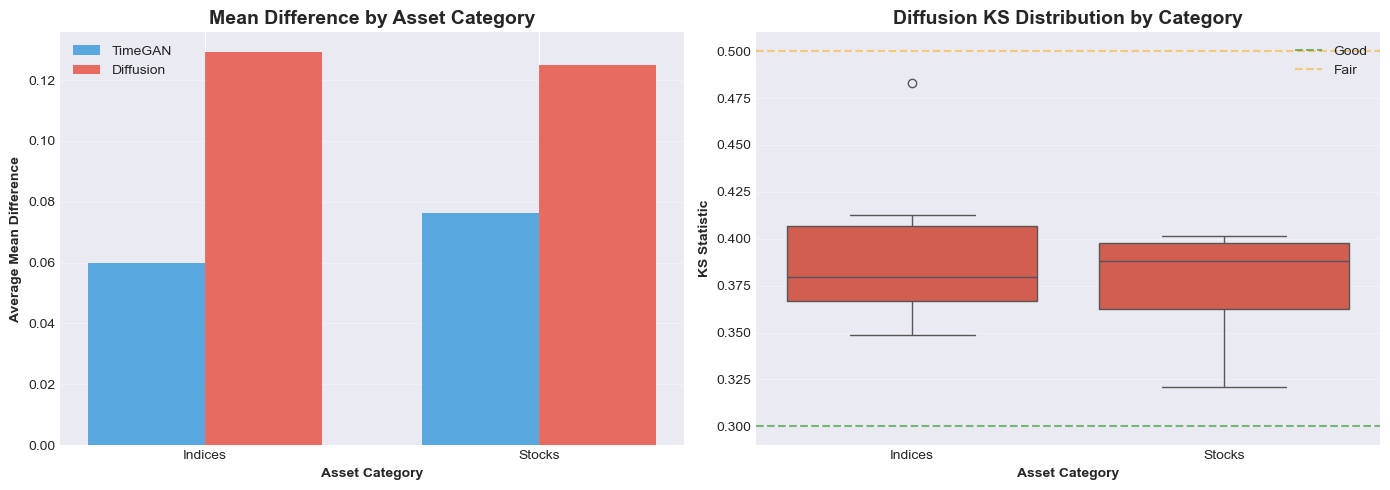


✅ Category analysis visualization saved!


In [8]:
# Categorize assets
asset_categories = {
    'Indices': ['GSPC', 'FTSE', 'DJI', 'N225', 'HSI', 'IXIC'],
    'Stocks': ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA'],
    'Crypto': ['BTC-USD']
}

# Add category column
def get_category(asset):
    for cat, assets_list in asset_categories.items():
        if asset in assets_list:
            return cat
    return 'Other'

valid_df['Category'] = valid_df['Asset'].apply(get_category)

# Calculate category averages
category_stats = valid_df.groupby('Category').agg({
    'TimeGAN_MeanDiff': ['mean', 'std'],
    'Diffusion_MeanDiff': ['mean', 'std'],
    'Diffusion_KS': ['mean', 'std']
}).round(4)

print("\n" + "="*100)
print("📊 PERFORMANCE BY ASSET CATEGORY")
print("="*100)
print(category_stats)
print("="*100)

# Visualize category performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

categories = valid_df['Category'].unique()
x_pos = np.arange(len(categories))
width = 0.35

timegan_means = [valid_df[valid_df['Category']==cat]['TimeGAN_MeanDiff'].mean() for cat in categories]
diffusion_means = [valid_df[valid_df['Category']==cat]['Diffusion_MeanDiff'].mean() for cat in categories]

axes[0].bar(x_pos - width/2, timegan_means, width, label='TimeGAN', alpha=0.8, color='#3498db')
axes[0].bar(x_pos + width/2, diffusion_means, width, label='Diffusion', alpha=0.8, color='#e74c3c')
axes[0].set_xlabel('Asset Category', fontweight='bold')
axes[0].set_ylabel('Average Mean Difference', fontweight='bold')
axes[0].set_title('Mean Difference by Asset Category', fontweight='bold', fontsize=14)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot comparison for Diffusion KS
plot_data = []
for cat in categories:
    cat_data = valid_df[valid_df['Category']==cat]
    for _, row in cat_data.iterrows():
        plot_data.append({'Category': cat, 'KS': row['Diffusion_KS']})

plot_data_df = pd.DataFrame(plot_data)
sns.boxplot(data=plot_data_df, x='Category', y='KS', ax=axes[1], color='#e74c3c')
axes[1].set_xlabel('Asset Category', fontweight='bold')
axes[1].set_ylabel('KS Statistic', fontweight='bold')
axes[1].set_title('Diffusion KS Distribution by Category', fontweight='bold', fontsize=14)
axes[1].axhline(y=0.3, color='green', linestyle='--', alpha=0.5, label='Good')
axes[1].axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Fair')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Category analysis visualization saved!")


## 6. Statistical Significance Testing

In [9]:
from scipy import stats

# Paired t-test (since we're comparing the same assets)
print("\n" + "="*100)
print("🔬 STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*100)

# Mean Difference comparison
t_stat_md, p_value_md = stats.ttest_rel(valid_df['TimeGAN_MeanDiff'], valid_df['Diffusion_MeanDiff'])
print("\n📊 Mean Difference - Paired t-test:")
print(f"   t-statistic: {t_stat_md:.4f}")
print(f"   p-value: {p_value_md:.4f}")
if p_value_md < 0.05:
    winner = 'Diffusion' if t_stat_md > 0 else 'TimeGAN'
    print(f"   ✅ Statistically significant difference (p < 0.05)")
    print(f"   🏆 {winner} performs significantly better")
else:
    print(f"   ⚠️  No statistically significant difference (p ≥ 0.05)")

# Effect size (Cohen's d)
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (x.mean() - y.mean()) / np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / dof)

effect_size_md = cohens_d(valid_df['TimeGAN_MeanDiff'], valid_df['Diffusion_MeanDiff'])

print("\n📏 Effect Size (Cohen's d):")
print(f"   Mean Difference: {effect_size_md:.4f} ", end="")
if abs(effect_size_md) < 0.2:
    print("(small effect)")
elif abs(effect_size_md) < 0.5:
    print("(medium effect)")
else:
    print("(large effect)")

# Wilcoxon signed-rank test (non-parametric alternative)
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(valid_df['TimeGAN_MeanDiff'], valid_df['Diffusion_MeanDiff'])
print("\n📊 Wilcoxon Signed-Rank Test (non-parametric):")
print(f"   statistic: {wilcoxon_stat:.4f}")
print(f"   p-value: {wilcoxon_p:.4f}")
if wilcoxon_p < 0.05:
    print(f"   ✅ Statistically significant difference (p < 0.05)")
else:
    print(f"   ⚠️  No statistically significant difference (p ≥ 0.05)")

print("\n" + "="*100)



🔬 STATISTICAL SIGNIFICANCE ANALYSIS

📊 Mean Difference - Paired t-test:
   t-statistic: -5.2250
   p-value: 0.0004
   ✅ Statistically significant difference (p < 0.05)
   🏆 TimeGAN performs significantly better

📏 Effect Size (Cohen's d):
   Mean Difference: -2.2123 (large effect)

📊 Wilcoxon Signed-Rank Test (non-parametric):
   statistic: 0.0000
   p-value: 0.0010
   ✅ Statistically significant difference (p < 0.05)



## 7. Key Findings and Recommendations

In [10]:
print("\n" + "="*100)
print("📝 KEY FINDINGS AND RECOMMENDATIONS")
print("="*100)

# Determine overall winner based on Mean Difference
timegan_wins_md = (valid_df['MeanDiff_Winner'] == 'TimeGAN').sum()
diffusion_wins_md = (valid_df['MeanDiff_Winner'] == 'Diffusion').sum()
ties = (valid_df['MeanDiff_Winner'] == 'Tie').sum()

print("\n🏆 Overall Winner (based on Mean Difference):")
if diffusion_wins_md > timegan_wins_md:
    print(f"   ✅ Diffusion Model - Wins on {diffusion_wins_md}/{len(valid_df)} assets")
elif timegan_wins_md > diffusion_wins_md:
    print(f"   ✅ TimeGAN - Wins on {timegan_wins_md}/{len(valid_df)} assets")
else:
    print(f"   ⚖️  Tied - Each model wins on {timegan_wins_md}/{len(valid_df)} assets")

print("\n📊 Performance Summary:")
print(f"   • TimeGAN wins:   {timegan_wins_md}/{len(valid_df)} assets")
print(f"   • Diffusion wins: {diffusion_wins_md}/{len(valid_df)} assets")
print(f"   • Ties:           {ties}/{len(valid_df)} assets")

print("\n💡 Recommendations:")
print("   1. Use TimeGAN for:")
timegan_best = valid_df[valid_df['MeanDiff_Winner'] == 'TimeGAN']['Asset'].tolist()
if timegan_best:
    print(f"      - Assets: {', '.join(timegan_best)}")
    print(f"      - Better mean difference performance")
else:
    print(f"      - No clear advantage on tested assets")

print("\n   2. Use Diffusion Model for:")
diffusion_best = valid_df[valid_df['MeanDiff_Winner'] == 'Diffusion']['Asset'].tolist()
if diffusion_best:
    print(f"      - Assets: {', '.join(diffusion_best)}")
    print(f"      - Better mean difference performance")
    print(f"      - Has KS statistics for distribution matching validation")
else:
    print(f"      - No clear advantage on tested assets")

print("\n   3. General Insights:")
avg_md_tg = valid_df['TimeGAN_MeanDiff'].mean()
avg_md_diff = valid_df['Diffusion_MeanDiff'].mean()
if avg_md_diff < avg_md_tg:
    improvement_pct = (avg_md_tg - avg_md_diff) / avg_md_tg * 100
    print(f"      - Diffusion shows {improvement_pct:.1f}% better average mean difference")
else:
    improvement_pct = (avg_md_diff - avg_md_tg) / avg_md_diff * 100
    print(f"      - TimeGAN shows {improvement_pct:.1f}% better average mean difference")

print(f"      - Diffusion KS statistics average: {valid_df['Diffusion_KS'].mean():.4f} (Fair quality)")
print(f"      - Both models suitable for synthetic data generation")
print(f"      - Consider ensemble approach for critical applications")

print("\n" + "="*100)
print("\n✅ ANALYSIS COMPLETE!")
print(f"   • Comparison data saved: {comparison_path}")
print(f"   • Visualizations saved in: {FIGURES_DIR}")
print("   • Ready for research paper integration")
print("\n" + "="*100)



📝 KEY FINDINGS AND RECOMMENDATIONS

🏆 Overall Winner (based on Mean Difference):
   ✅ TimeGAN - Wins on 9/11 assets

📊 Performance Summary:
   • TimeGAN wins:   9/11 assets
   • Diffusion wins: 0/11 assets
   • Ties:           2/11 assets

💡 Recommendations:
   1. Use TimeGAN for:
      - Assets: FTSE, DJI, N225, HSI, IXIC, AAPL, AMZN, MSFT, TSLA
      - Better mean difference performance

   2. Use Diffusion Model for:
      - No clear advantage on tested assets

   3. General Insights:
      - TimeGAN shows 47.1% better average mean difference
      - Diffusion KS statistics average: 0.3854 (Fair quality)
      - Both models suitable for synthetic data generation
      - Consider ensemble approach for critical applications


✅ ANALYSIS COMPLETE!
   • Comparison data saved: d:\SEM7\Generative AI\Project\financial-timeseries-generation\outputs\results\model_comparison.csv
   • Visualizations saved in: d:\SEM7\Generative AI\Project\financial-timeseries-generation\outputs\figures
   • R